In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda
cuda


In [18]:
!wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
from IPython.display import Audio
Audio('gt_bach.wav')
import torchaudio
audio, sr = torchaudio.load('./gt_bach.wav')

--2024-09-20 12:49:01--  https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
Resolving www.vincentsitzmann.com (www.vincentsitzmann.com)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to www.vincentsitzmann.com (www.vincentsitzmann.com)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: ‘gt_bach.wav.2’

gt_bach.wav.2       100%[===================>]   1.17M  --.-KB/s    in 0.07s   

2024-09-20 12:49:01 (17.0 MB/s) - ‘gt_bach.wav.2’ saved [1232886/1232886]

--2024-09-20 12:53:56--  https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
Resolving www.vincentsitzmann.com (www.vincentsitzmann.com)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to www.vincentsitzmann.com (www.vincentsitzmann.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: ‘gt_bach.wav.3’

gt_bach.wav.3       

In [19]:
print(audio.shape)
audio = audio[0]

tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

audio

torch.Size([1, 308207])
Audio length: 6.988820861678004 seconds


tensor([0.0000, 0.0000, 0.0000,  ..., 0.0473, 0.0297, 0.0168])

torch.Size([1, 308207])
Audio length: 6.988820861678004 seconds


tensor([0.0000, 0.0000, 0.0000,  ..., 0.0473, 0.0297, 0.0168])

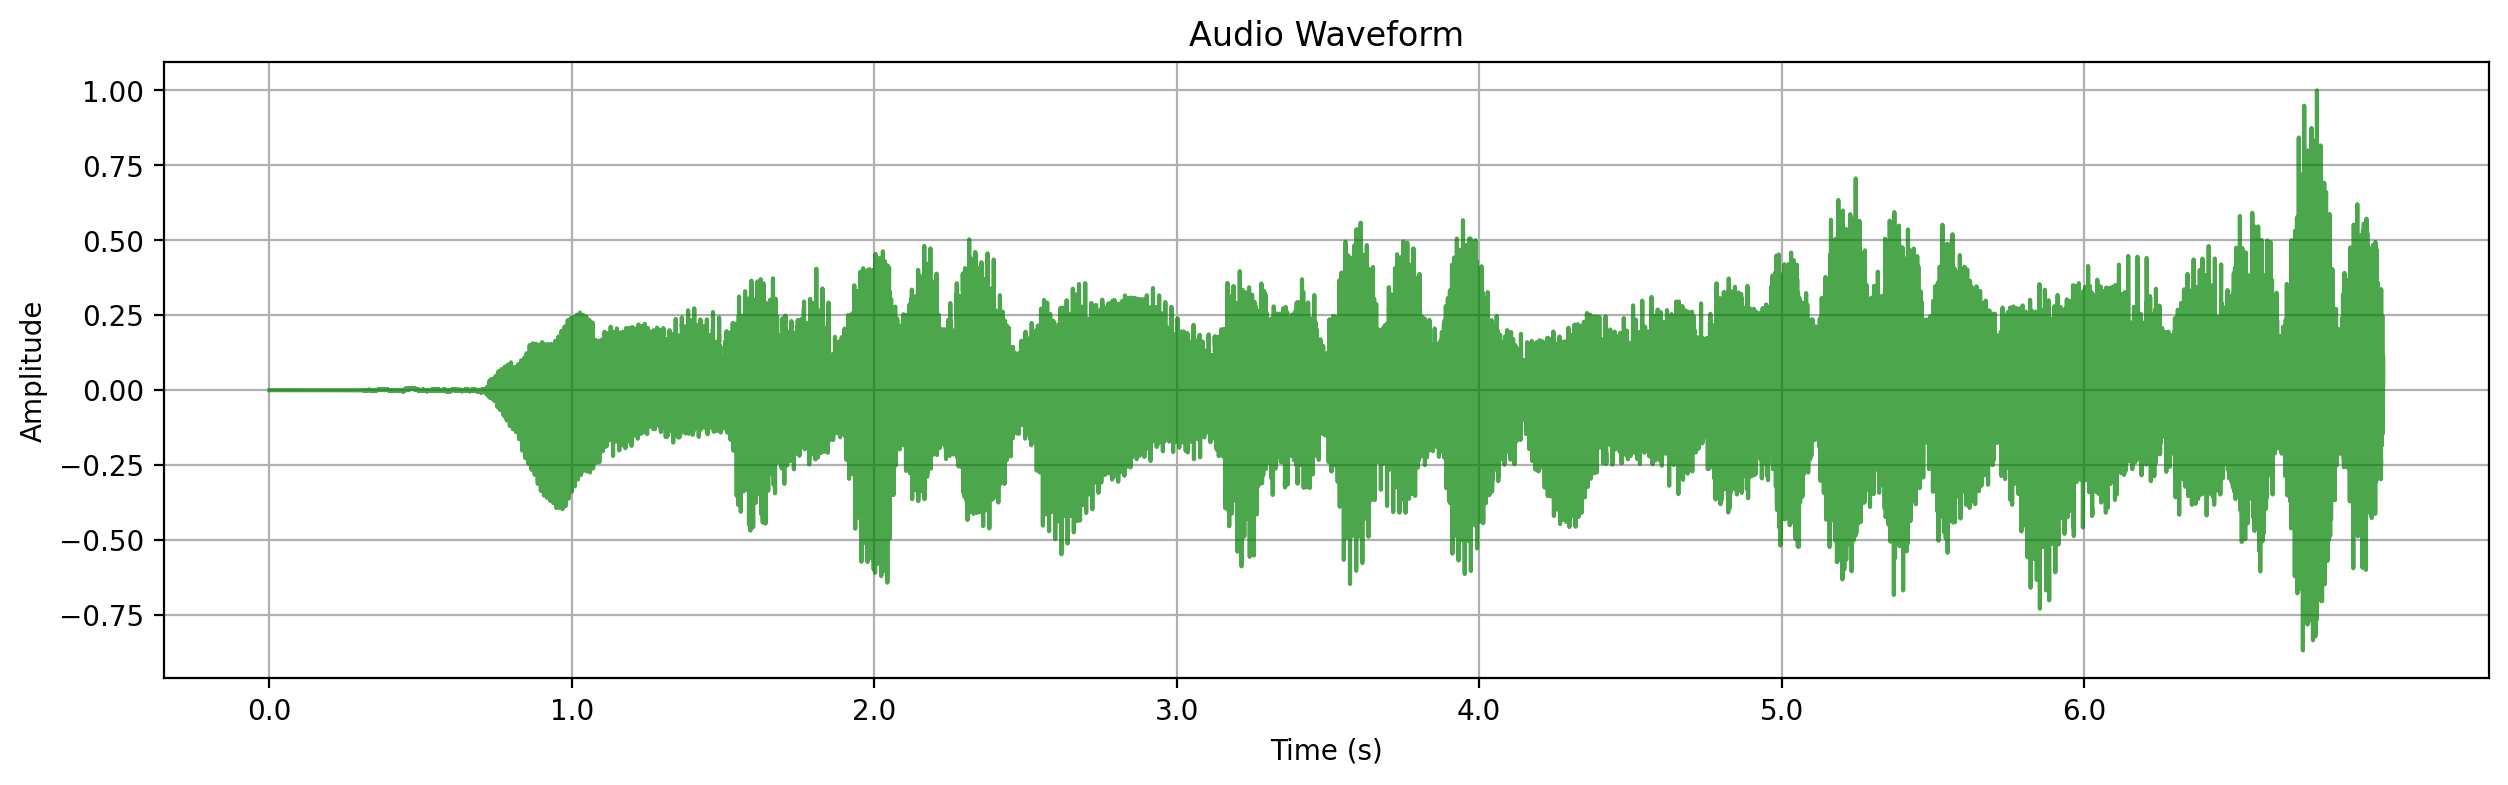

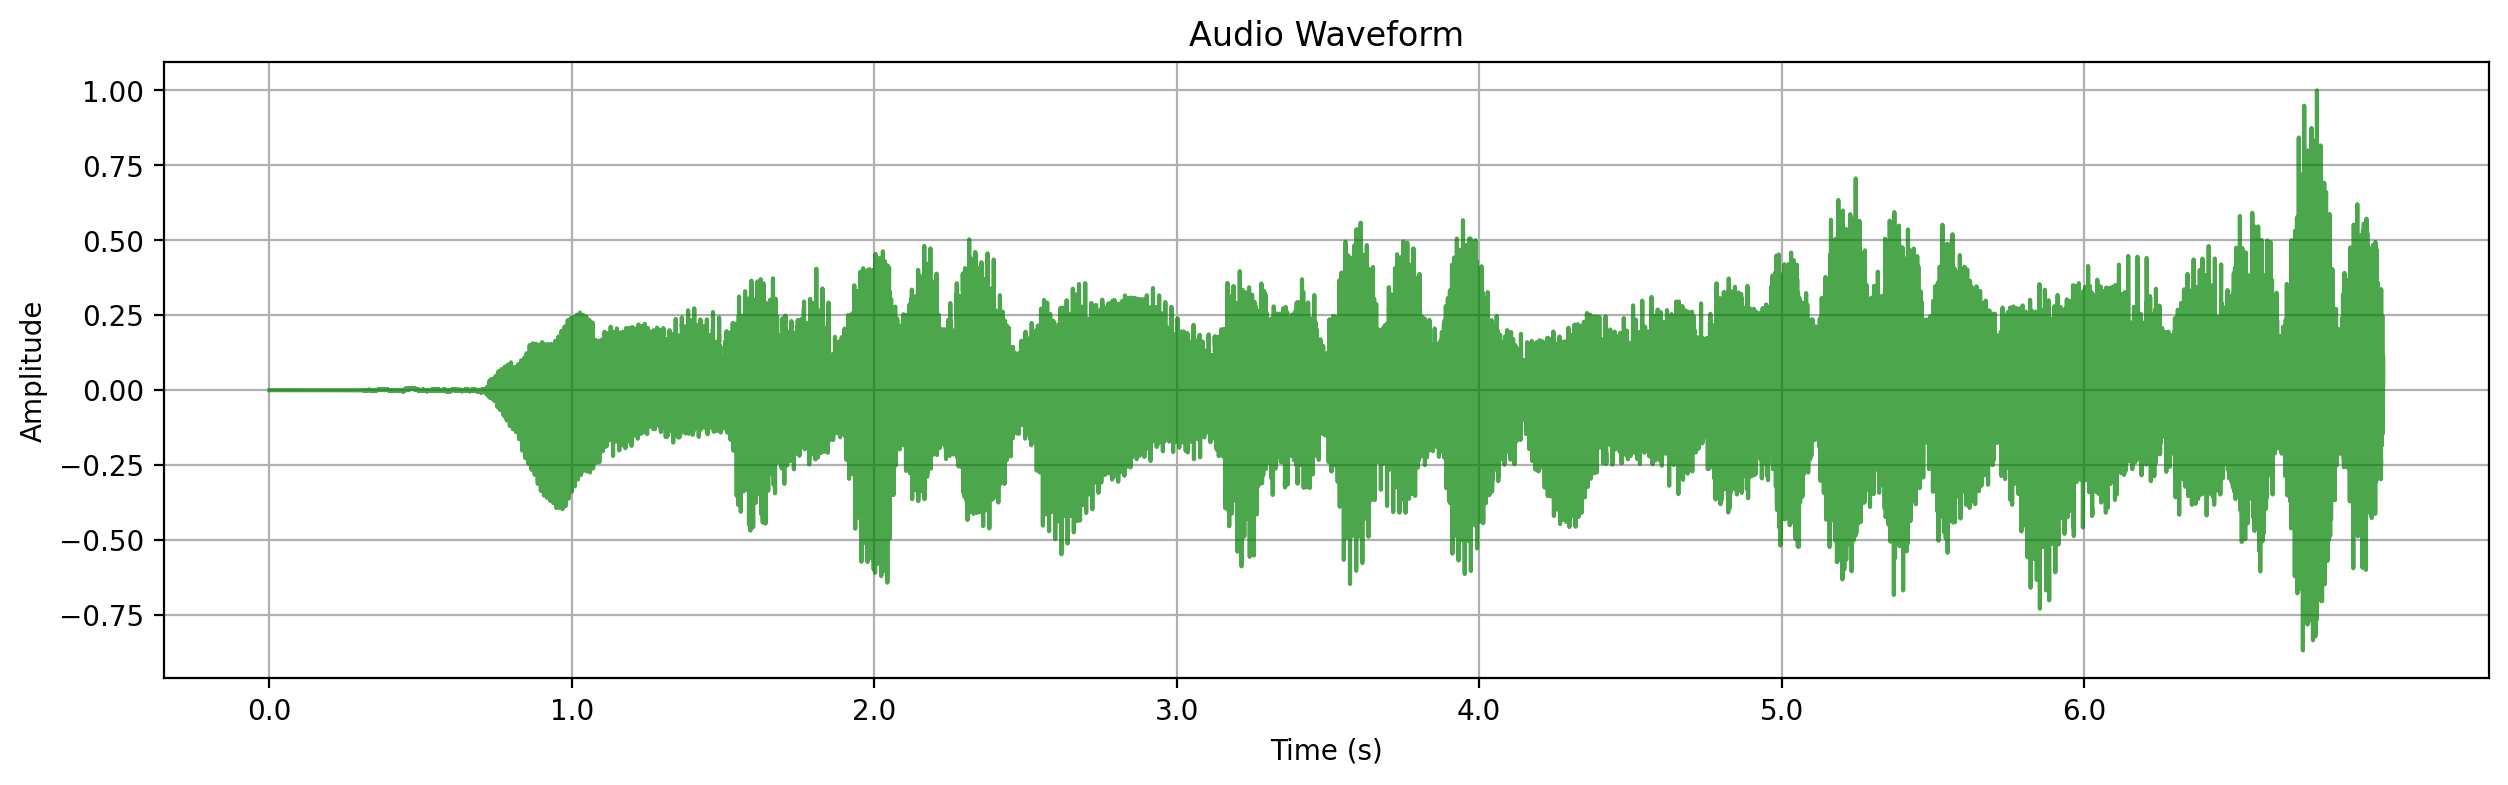

In [20]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [21]:
audio = audio[-5 * sr:]
print(audio.shape)
print(audio)

torch.Size([220500])
tensor([-0.4993, -0.4846, -0.4692,  ...,  0.0473,  0.0297,  0.0168])
torch.Size([220500])
tensor([-0.4993, -0.4846, -0.4692,  ...,  0.0473,  0.0297,  0.0168])


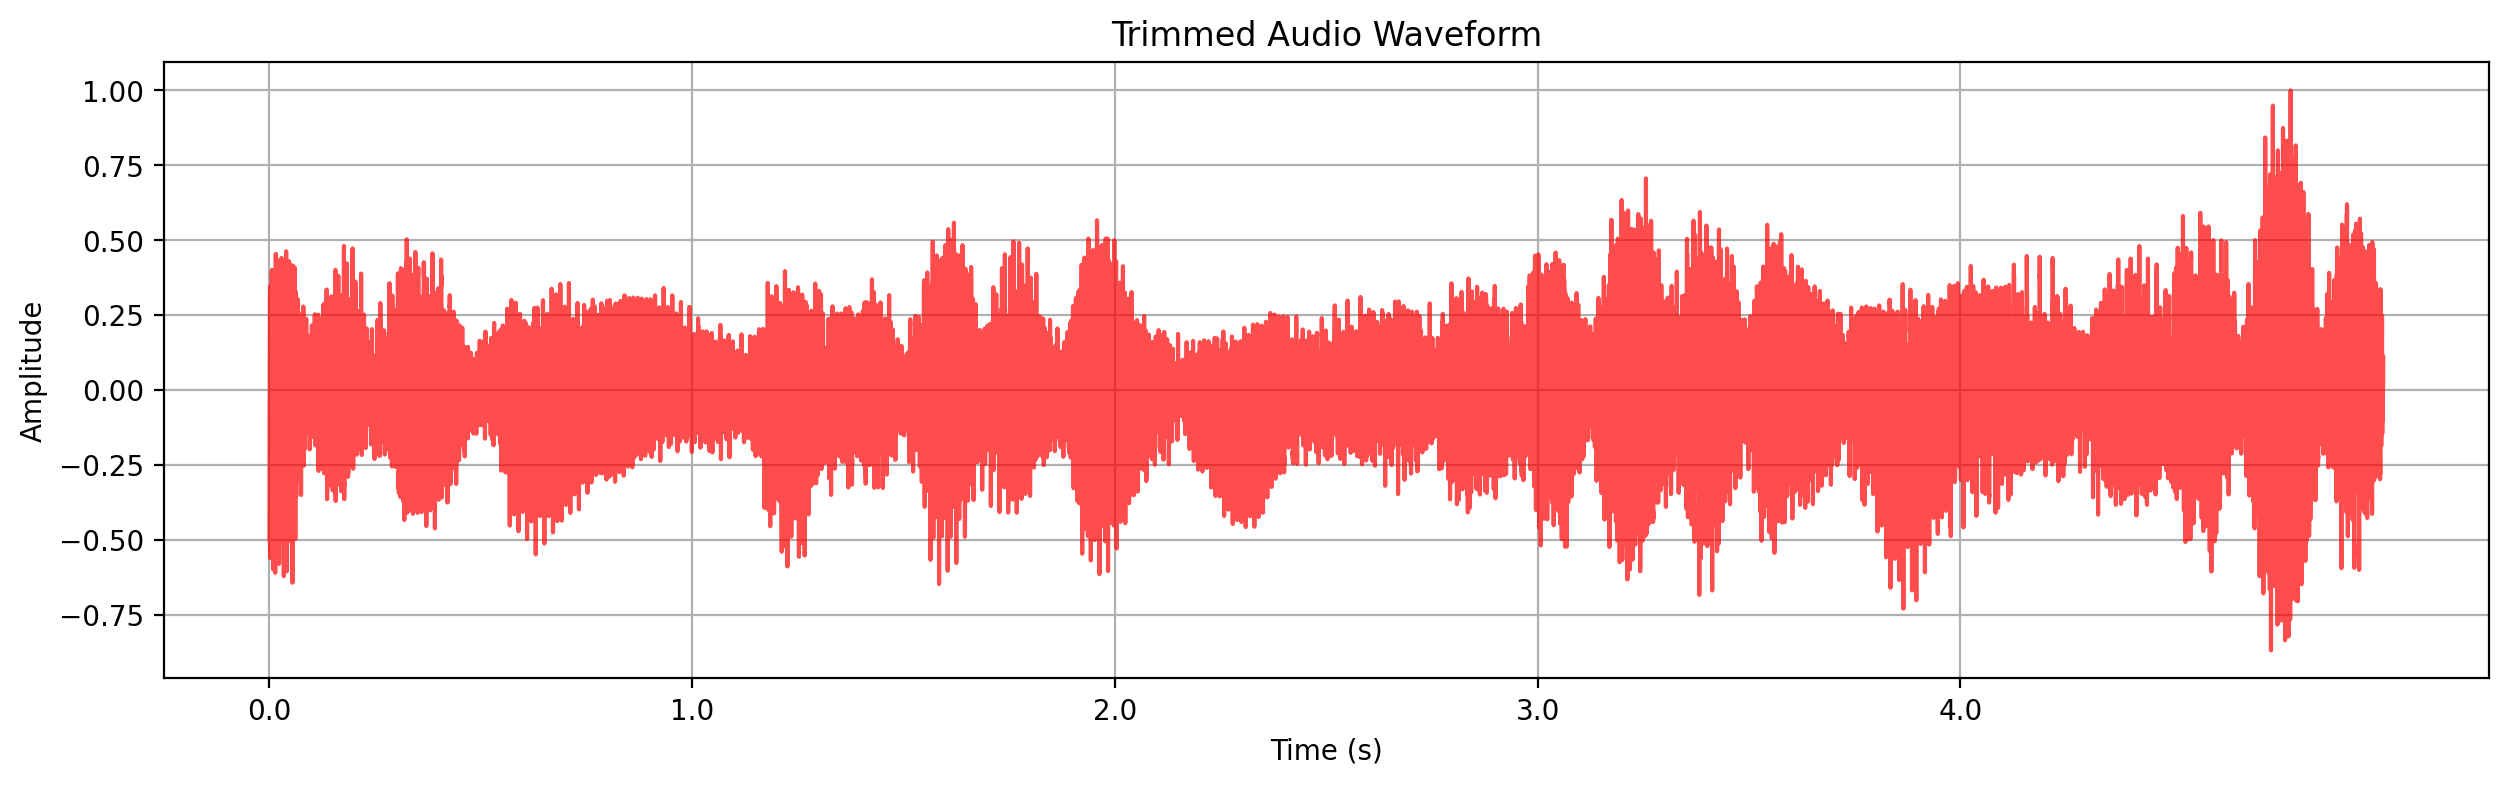

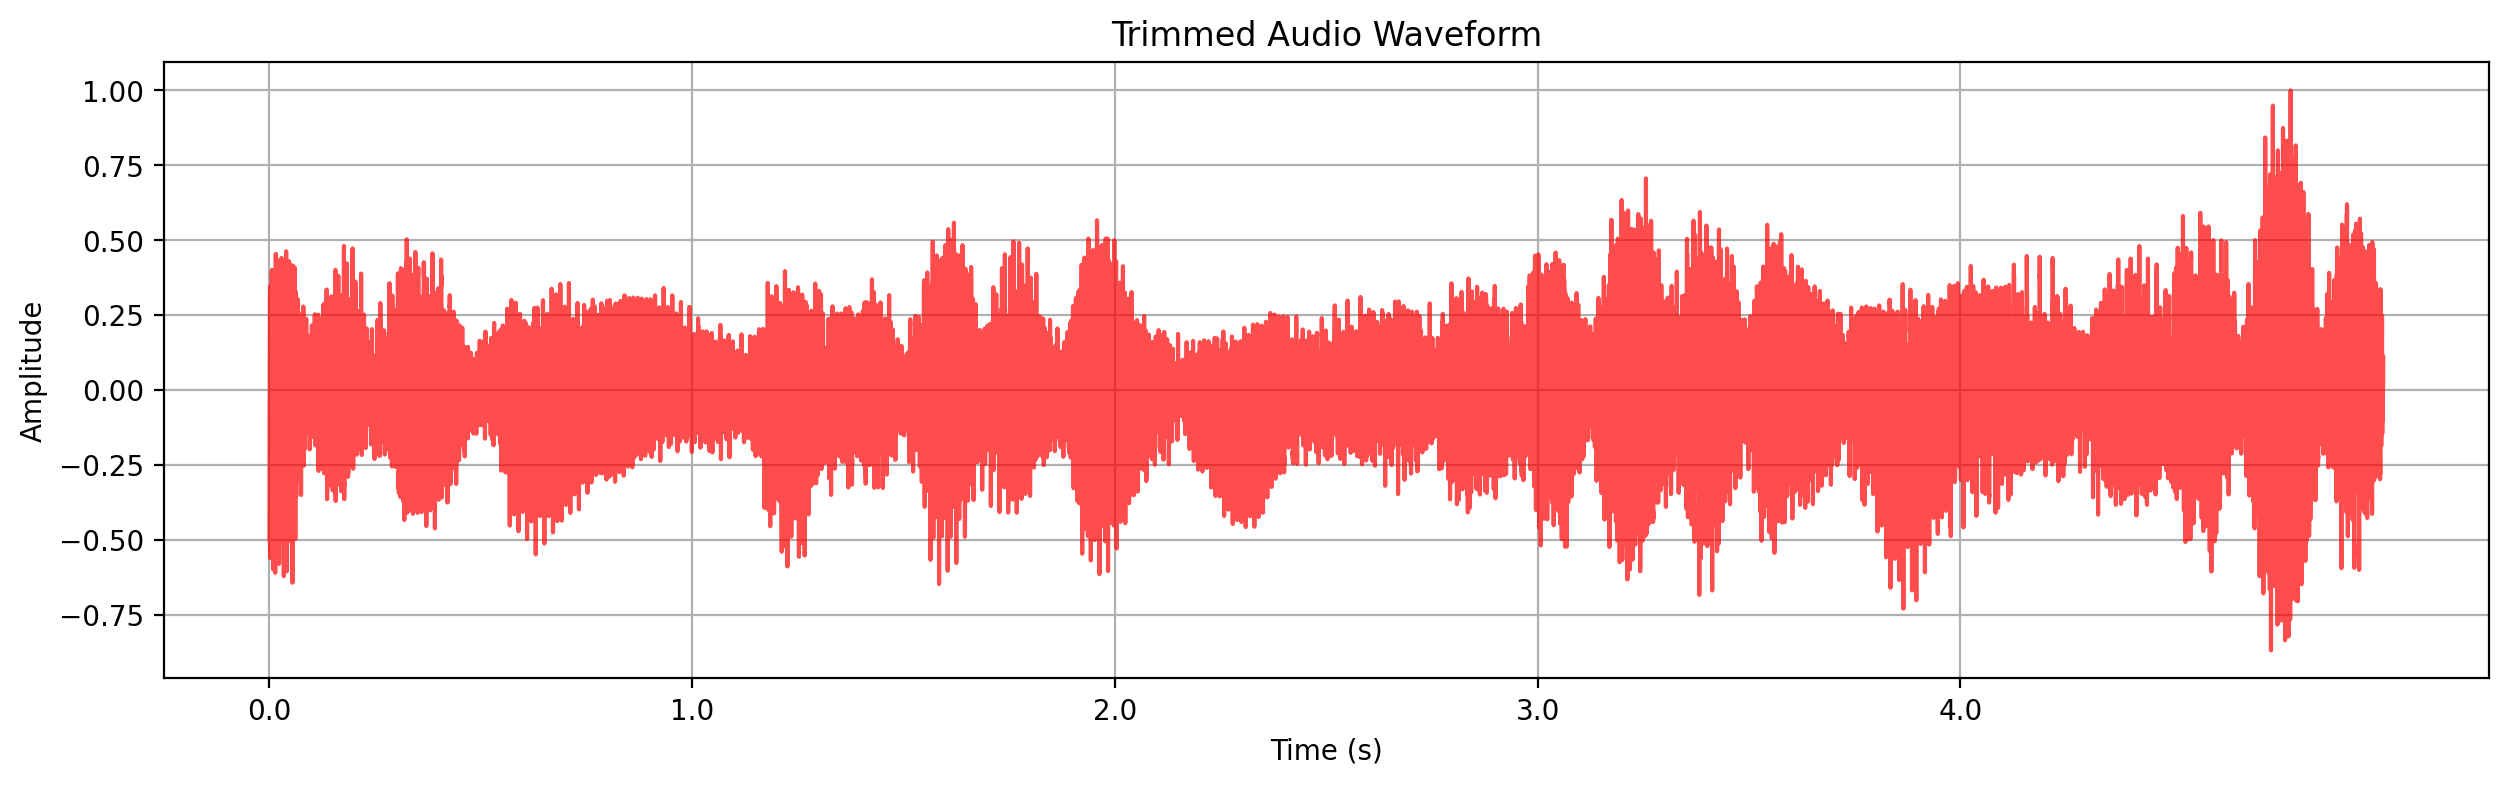

In [22]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

In [23]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)
Audio(audio, rate = sr)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [24]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)
num_features = 4200
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 4200])
tensor([[-0.0086, -0.0218, -0.0060,  ..., -0.0146,  0.0215, -0.0189],
        [-0.0102, -0.0216, -0.0059,  ..., -0.0161,  0.0218, -0.0189],
        [-0.0118, -0.0212, -0.0058,  ..., -0.0174,  0.0209, -0.0190],
        ...,
        [ 0.0069, -0.0154,  0.0036,  ...,  0.0028,  0.0099,  0.0189],
        [ 0.0086, -0.0140,  0.0037,  ...,  0.0048,  0.0049,  0.0190],
        [ 0.0102, -0.0126,  0.0038,  ...,  0.0067, -0.0002,  0.0190]])
torch.Size([220500, 4200])
tensor([[-0.0086, -0.0218, -0.0060,  ..., -0.0146,  0.0215, -0.0189],
        [-0.0102, -0.0216, -0.0059,  ..., -0.0161,  0.0218, -0.0189],
        [-0.0118, -0.0212, -0.0058,  ..., -0.0174,  0.0209, -0.0190],
        ...,
        [ 0.0069, -0.0154,  0.0036,  ...,  0.0028,  0.0099,  0.0189],
        [ 0.0086, -0.0140,  0.0037,  ...,  0.0048,  0.0049,  0.0190],
        [ 0.0102, -0.0126,  0.0038,  ...,  0.0067, -0.0002,  0.0190]])


In [25]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)
(220500,)


In [26]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [27]:
print(pred_audio)
print(audio)

[-0.09037939 -0.10056935 -0.11058983 ...  0.01377478  0.01176594
  0.01073998]
tensor([-0.4993, -0.4846, -0.4692,  ...,  0.0473,  0.0297,  0.0168])
[-0.09037939 -0.10056935 -0.11058983 ...  0.01377478  0.01176594
  0.01073998]
tensor([-0.4993, -0.4846, -0.4692,  ...,  0.0473,  0.0297,  0.0168])


In [28]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(63.432503, 23431.66)

(63.432503, 23431.66)

In [29]:
Audio(pred_audio, rate = sr)

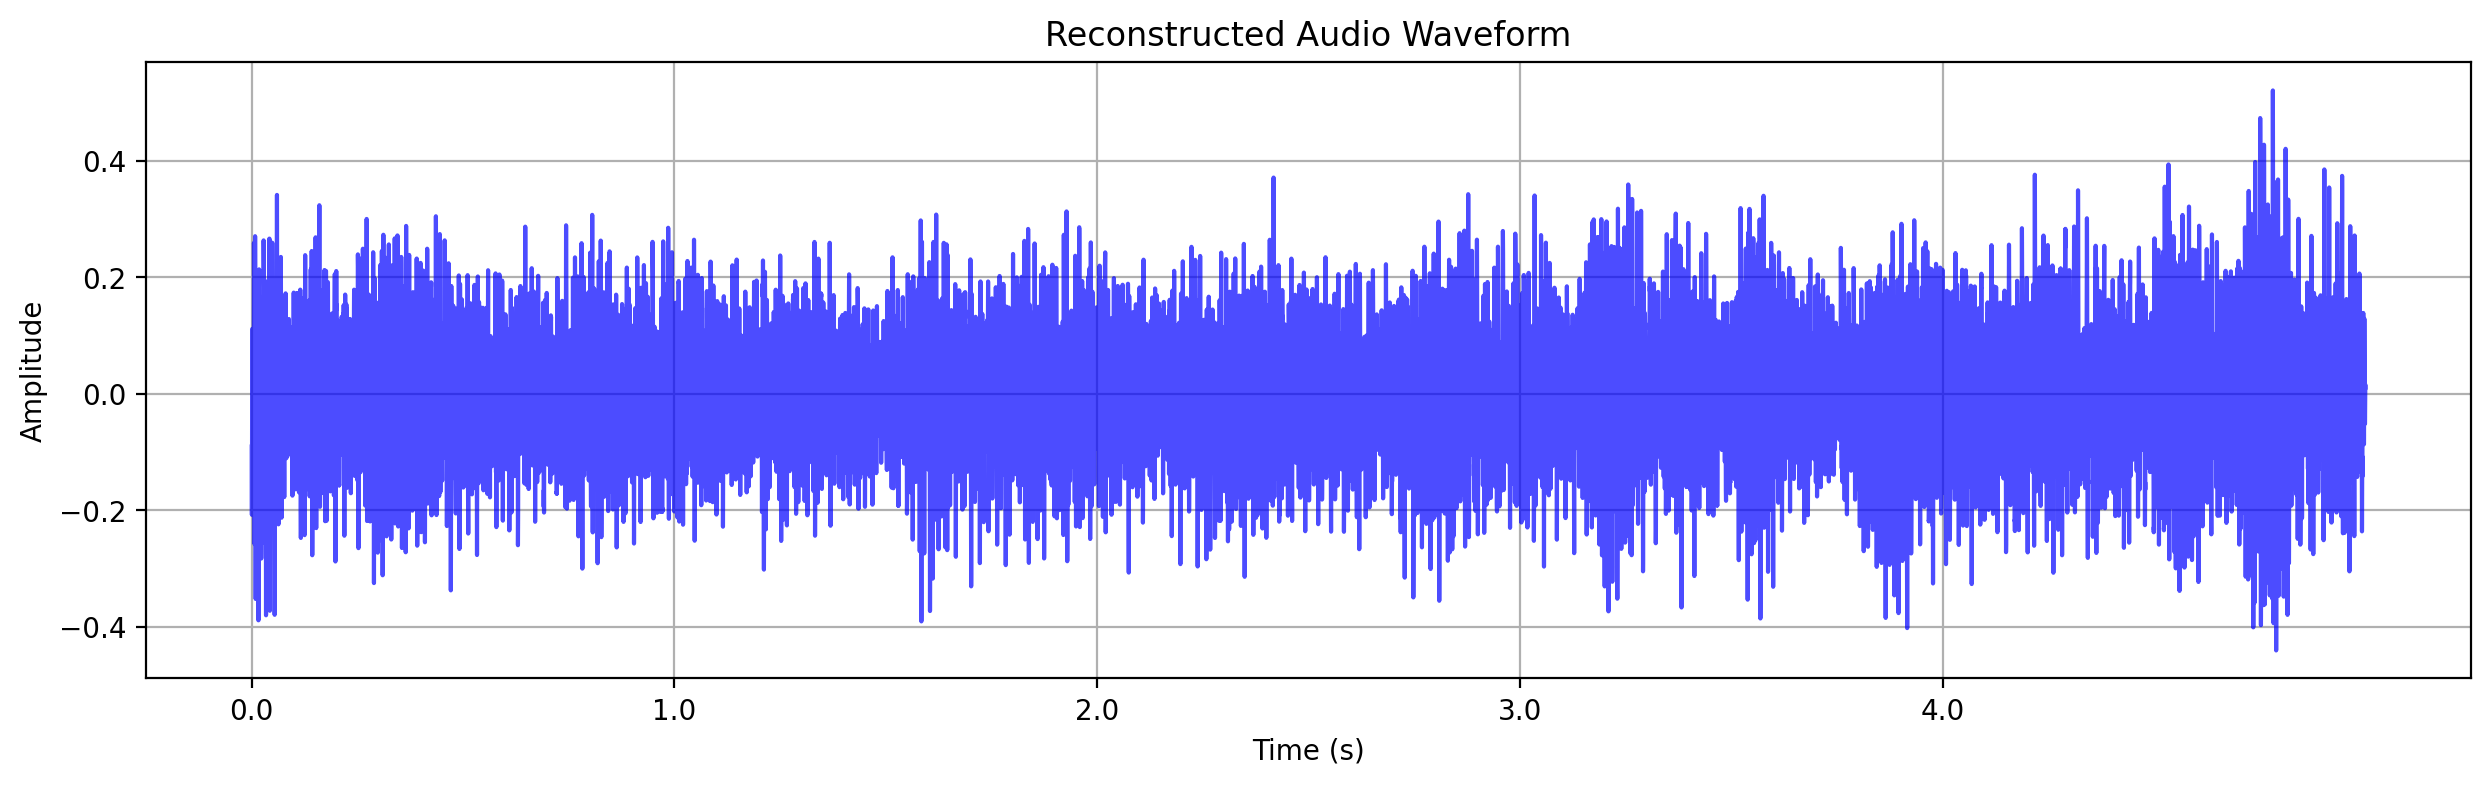

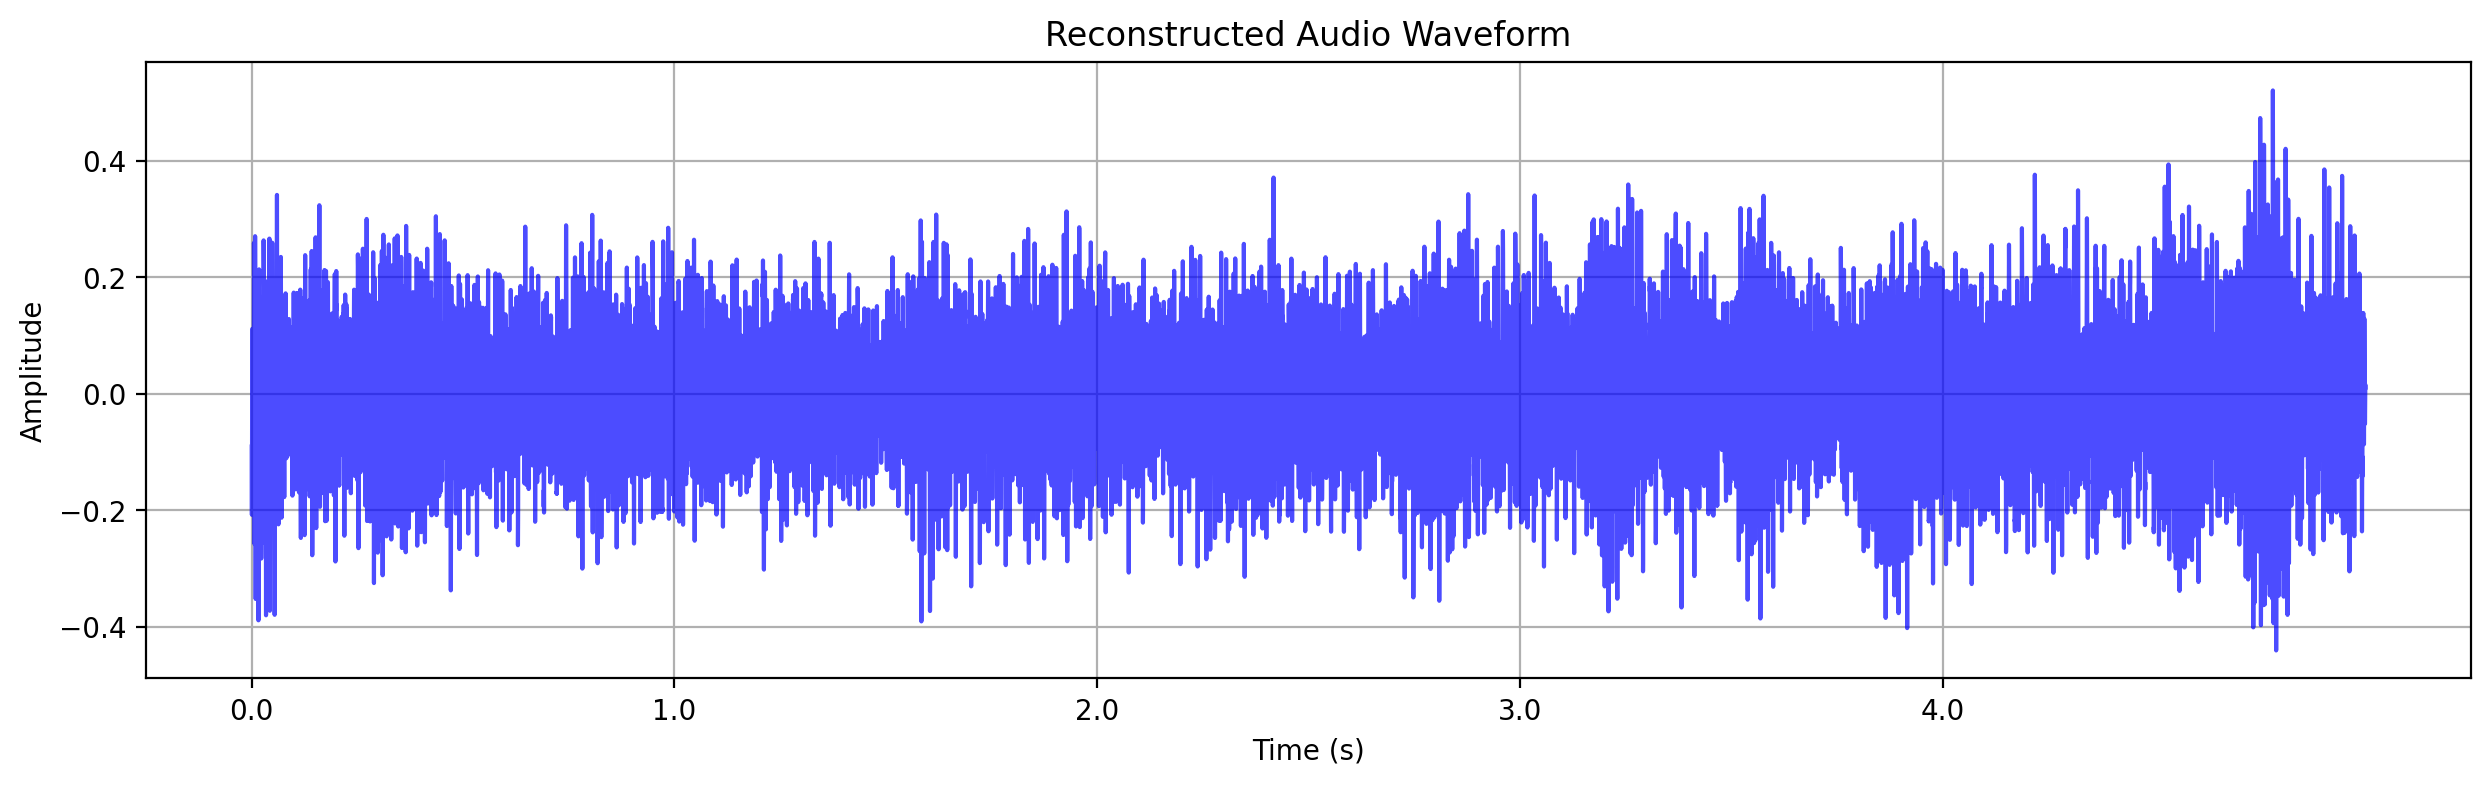

In [30]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

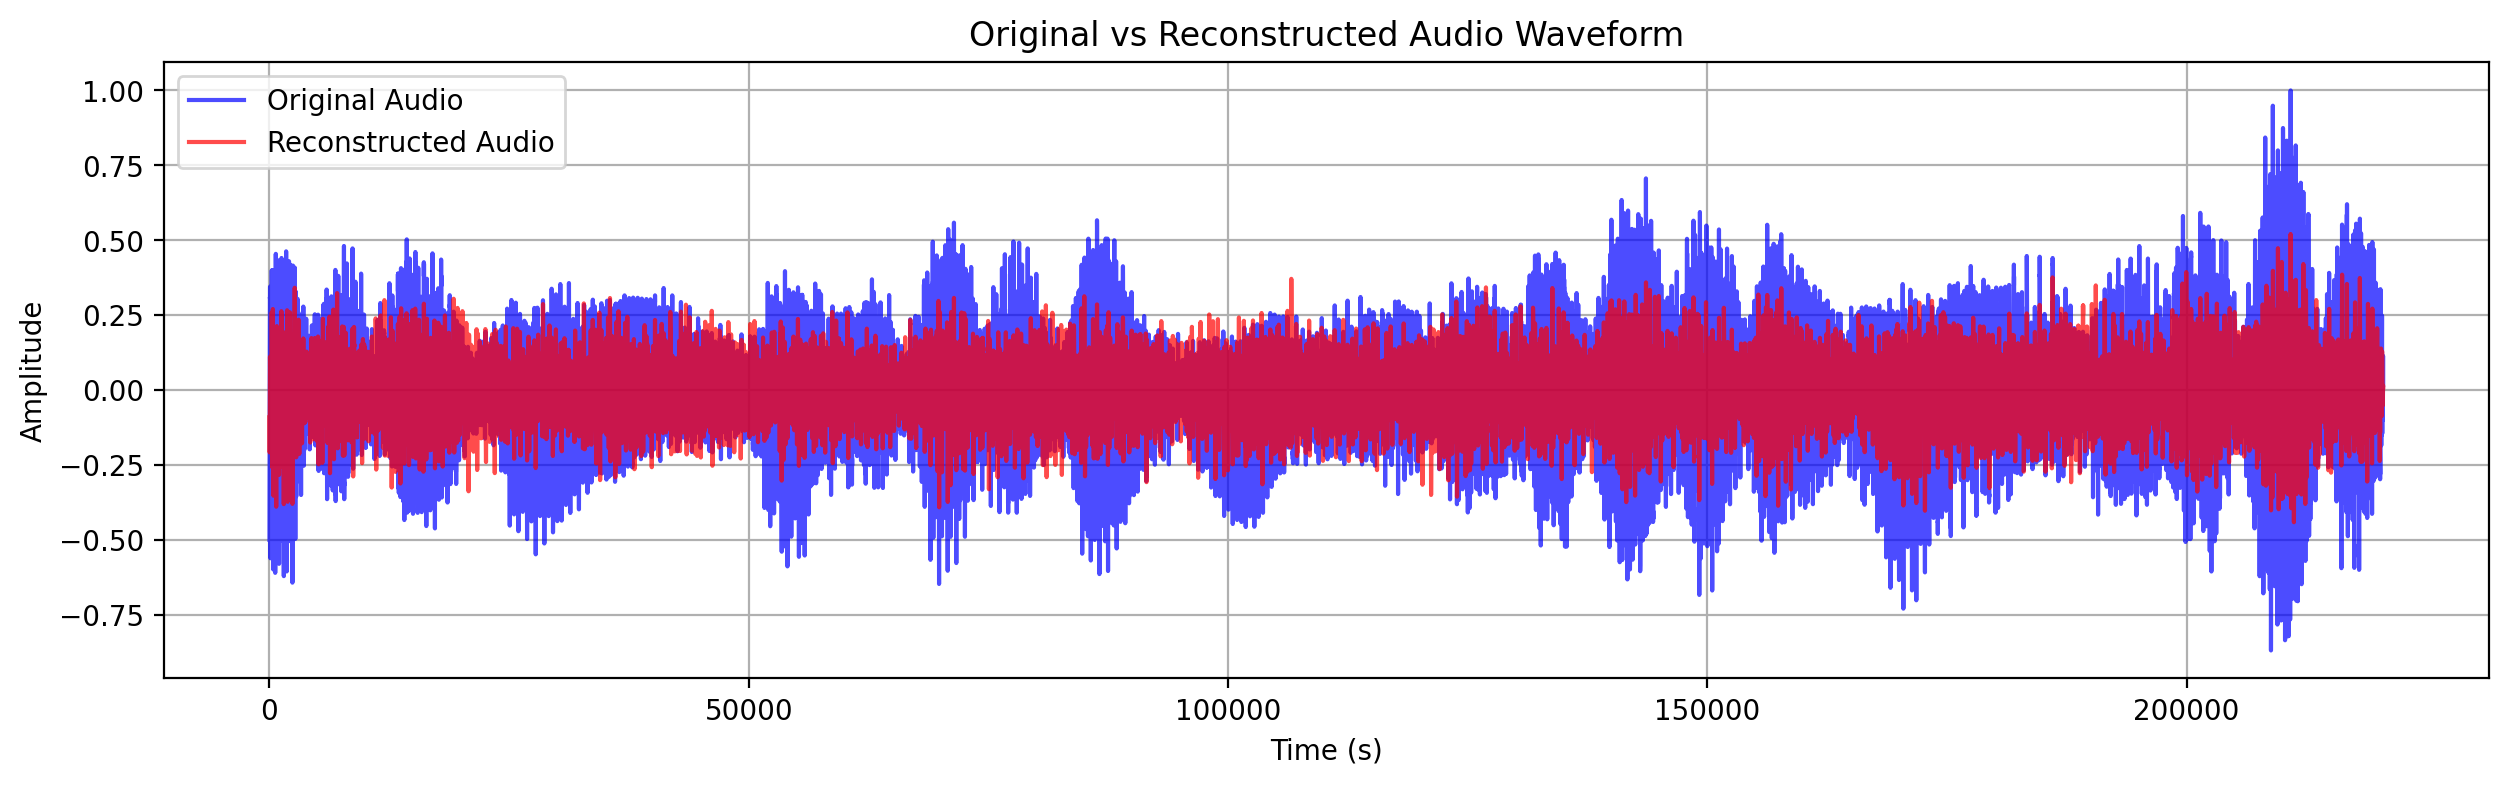

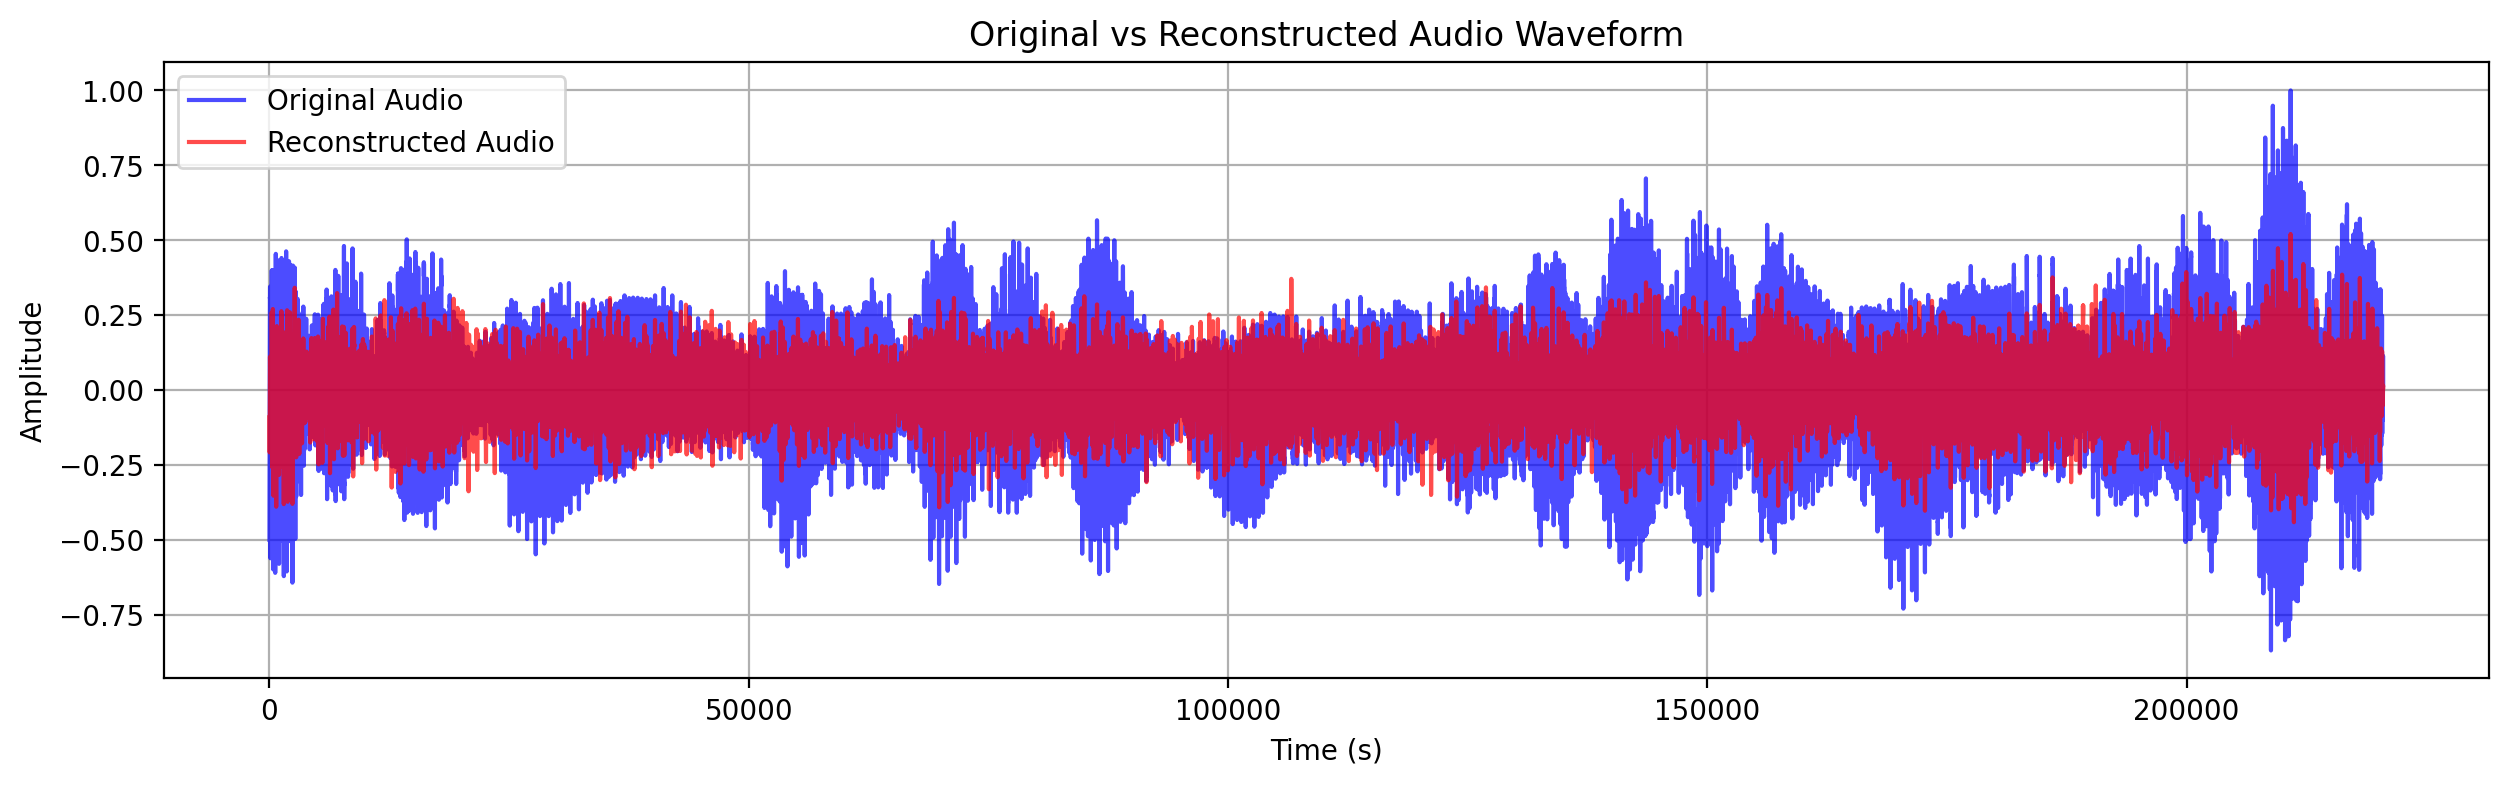

In [31]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [32]:
import numpy as np

# RMSE calculation
rmse = np.sqrt(np.mean((pred_audio - audio.numpy())**2))
print(f"RMSE: {rmse}")

# PSNR calculation
max_value = np.max(audio.numpy())  # max value of the original audio
psnr = 20 * np.log10(max_value / rmse)
print(f"PSNR: {psnr} dB")


RMSE: 0.13508513569831848
PSNR: 17.38784909248352 dB
RMSE: 0.13508513569831848
PSNR: 17.38784909248352 dB
